In [1]:
import os
import numpy as np
import xarray as xr

import pygmt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes

import matplotlib.pyplot as plt
import cmocean

In [71]:
# S-MODE field campaign settings
map_extent     = [-126., -121., 36., 39.]

# Operations Area corners (see experimental plan at https://docs.google.com/document/d/15TvXY8myX7MdzyIUlb4i7SU77kgnwSf_/edit?pli=1)
oparea_corners = {'longitude': [-124.0991, -123.1939, -122.6851,
                                -124.4067, -124.81, -124.8, -124.0991],
                  'latitude': [37.7545, 37.7957, 37.1011, 36.2889,
                               37.16, 37.9, 37.7545]       
                 }

figdir  = 'img/'
filename = 'SMODE_OperationsArea'
extension = ['png','pdf']
figproperties = dict(dpi=200,bbox_inches='tight')

### [pygmt](https://www.pygmt.org/v0.2.1/index.html): postscript GMT figure

Somewhat cryptic syntax but gorgeous maps. Requires GMT 6 in addition to pygmt.

In [3]:
# Settings
topo_data = '@earth_relief_30s'
proj = 'M6i'

In [7]:
# Make the figure
fig = pygmt.Figure()

# High-res topography
pygmt.makecpt(
    cmap='bathy',
    series='-7010/-10/10',
    continuous=True
)

fig.grdimage(
    grid=topo_data,
    region=map_extent,
    projection=proj,
    shading=True,
    frame="ag"
    )


fig.grdcontour(
    grid=topo_data,
    interval=100,
    annotation="100+f6p",
    limit="-210/-10",
    pen="a0.15p",
    )

fig.grdcontour(
    grid=topo_data,
    interval=1000,
    annotation="1000+f6p",
    limit="-5000/-1000",
    pen="a0.15p",
    )


# Operations area
fig.plot(
    x=oparea_corners['longitude'],
    y=oparea_corners['latitude'],
    color='gray30@40',
    pen='3p,black',
    )

# Coast
fig.coast(
    shorelines=True,
    resolution='f',land='black')

# Legends and text
fig.text(
    x=[-123.85],
    y=[37.2],
    text='S-MODE Operations Area',  
    font='11p,Helvetica-Bold,white',
    angle=27,
    )

fig.show()

[fig.savefig(os.path.join(figdir,filename+'_gmt.'+ext),**figproperties) for ext in extension]

   **** WARNING: .setopacityalpha is deprecated (as of 9.53.0) and will be removed in a future release
   **** See .setfillconstantalpha/.setalphaisshape for the improved solution
   **** WARNING: .setopacityalpha is deprecated (as of 9.53.0) and will be removed in a future release
   **** See .setfillconstantalpha/.setalphaisshape for the improved solution


GPL Ghostscript 9.54.0: **** Could not open the file 'img/SMODE_OperationsArea_gmt.png'.
GPL Ghostscript 9.54.0: Unrecoverable error, exit code 1
psconvert [ERROR]: System call [gs -q -dNOPAUSE -dBATCH -dNOSAFER -dPDFSETTINGS=/prepress -dDownsampleColorImages=false -dDownsampleGrayImages=false -dDownsampleMonoImages=false -dUseFlateCompression=true -dEmbedAllFonts=true -dSubsetFonts=true -dMonoImageFilter=/FlateEncode -dAutoFilterGrayImages=false -dGrayImageFilter=/FlateEncode -dAutoFilterColorImages=false -dColorImageFilter=/FlateEncode -dSCANCONVERTERTYPE=2 -dALLOWPSTRANSPARENCY -dMaxBitmap=2147483647 -dUseFastColor=true -dGraphicsAlphaBits=2 -dTextAlphaBits=2 -sDEVICE=png16m  -g1693x1261 -r250 -sOutputFile='img/SMODE_OperationsArea_gmt.png' '/home/cer19004/.gmt/sessions/gmt_session.77653/gmt_2_intermediate.pdf'] returned error 256.


Error: /invalidfileaccess in --showpage--
Operand stack:
   1   true
Execution stack:
   %interp_exit   .runexec2   --nostringval--   showpage   --nostringval--   2   %stopped_push   --nostringval--   showpage   showpage   false   1   %stopped_push   1974   1   3   %oparray_pop   1973   1   3   %oparray_pop   1961   1   3   %oparray_pop   1962   1   3   %oparray_pop   showpage   showpage   2   1   1   showpage   %for_pos_int_continue   1965   1   7   %oparray_pop   showpage   showpage   1824   0   9   %oparray_pop   showpage   showpage
Dictionary stack:
   --dict:773/1123(ro)(G)--   --dict:1/20(G)--   --dict:81/200(L)--   --dict:81/200(L)--   --dict:134/256(ro)(G)--   --dict:324/325(ro)(G)--   --dict:33/64(L)--   --dict:6/9(L)--   --dict:6/20(L)--
Current allocation mode is local
Last OS error: No such file or directory


GMTCLibError: Module 'psconvert' failed with status code 78:
psconvert [ERROR]: System call [gs -q -dNOPAUSE -dBATCH -dNOSAFER -dPDFSETTINGS=/prepress -dDownsampleColorImages=false -dDownsampleGrayImages=false -dDownsampleMonoImages=false -dUseFlateCompression=true -dEmbedAllFonts=true -dSubsetFonts=true -dMonoImageFilter=/FlateEncode -dAutoFilterGrayImages=false -dGrayImageFilter=/FlateEncode -dAutoFilterColorImages=false -dColorImageFilter=/FlateEncode -dSCANCONVERTERTYPE=2 -dALLOWPSTRANSPARENCY -dMaxBitmap=2147483647 -dUseFastColor=true -dGraphicsAlphaBits=2 -dTextAlphaBits=2 -sDEVICE=png16m  -g1693x1261 -r250 -sOutputFile='img/SMODE_OperationsArea_gmt.png' '/home/cer19004/.gmt/sessions/gmt_session.77653/gmt_2_intermediate.pdf'] returned error 256.

In [ ]:
!open -a Preview img/SMODE_OperationsArea_gmt.pdf  # this only works on the Mac

### [cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html)
A bit more intuitive (but clunky) syntax and decent looking maps. Maps could be beautified, but that takes a lot of work.

The old NaturalEarth server is broken (9/22/2021). Features may have to manually downloaded and unzipped (see https://github.com/SciTools/cartopy/issues/1849).

In [4]:
# get slice of ETOPO1 data from WHOI's GEOPORT thredds
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bathy = xr.open_dataset(url)
bathy = bathy.sel(lon=slice(map_extent[0],map_extent[1]),lat=slice(map_extent[2],map_extent[3]))

In [5]:
projection = ccrs.PlateCarree(central_longitude=(map_extent[0]+map_extent[1])/2)
map_axes = (GeoAxes,{'map_projection':projection})

In [6]:
import matplotlib as mpl
mpl.rcParams['contour.negative_linestyle']= 'solid'

[None, None]

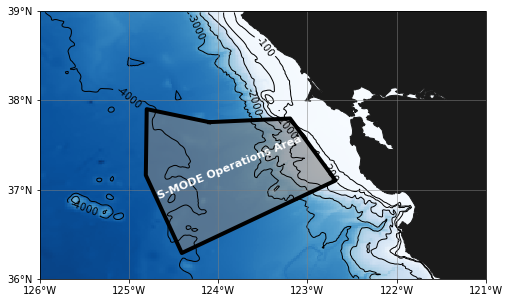

In [72]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111, projection=projection)     

_ = ax.set_extent(map_extent)


# Topography
db=1
# bathy['topo'].isel(lon=slice(0,-1,db),lat=slice(0,-1,db)).plot.contourf(
#         ax=ax,levels=np.arange(-5020,0,20),
#         add_colorbar=False, shading='flat',
#         extend='neither',cmap='Blues_r',
#         transform=ccrs.PlateCarree()
# )

bathy['topo'].isel(lon=slice(0,-1,db),lat=slice(0,-1,db)).plot.pcolormesh(
        ax=ax,vmin=-5020,vmax=0,
        add_colorbar=False, shading='flat',
        extend='neither',cmap='Blues_r',
        transform=ccrs.PlateCarree()
)


CS = bathy['topo'].isel(lon=slice(0,-1,db),lat=slice(0,-1,db)).plot.contour(
              ax=ax,levels=[-5000,-4000,-3000,-2000,-1000,-200,-100],
              colors='k',linewidths=1,
              transform=ccrs.PlateCarree()
)

ax.clabel(CS, CS.levels, inline=True, fmt='%i', fontsize=10)


# Axis labels
ax.set_yticks(np.arange(36,40,1), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-126,-120,1), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('')
ax.set_ylabel('')


# Continent
_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                    edgecolor='face', facecolor='0.1')
                  )

# Gridlines
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl.xlocator = mticker.FixedLocator(np.arange(-126,-120,1))
gl.ylocator = mticker.FixedLocator(np.arange(36,40,1))


# SMODE area
ax.plot(oparea_corners['longitude'],
        oparea_corners['latitude'],
        transform=ccrs.PlateCarree(),
        color='k',linewidth=4
       )

ax.fill(oparea_corners['longitude'],
        oparea_corners['latitude'],
        transform=ccrs.PlateCarree(),
        color='0.5', alpha=0.6,
       )

ax.text(-124.69, 36.9, 
        'S-MODE Operations Area',
        color='w',
        fontsize=11,
        fontweight='bold',
        rotation=22,
        transform=ccrs.PlateCarree(),
       )

[fig.savefig(os.path.join(figdir,filename+'_cartopy.'+ext),**figproperties) for ext in extension]